## Loading the dataset
After downloading the dataset from http://ufldl.stanford.edu/housenumbers/ in the second variant (32x32 images with a single number centered)

In [1]:
import matplotlib.pyplot as plt
import numpy as np, random, os
import tensorflow as tf
from tensorflow.keras import layers, models
import json

#Read the datasets into memory
from scipy.io import loadmat

train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')
train_img, train_lbs = train['X'], train['y']
test_img, test_lbs = test['X'], test['y']

train_img.shape, train_lbs.shape, test_img.shape, test_lbs.shape

((32, 32, 3, 73257), (73257, 1), (32, 32, 3, 26032), (26032, 1))

In [2]:
#reshape the arrays to have the sample number as the first index

train_img = np.transpose(train_img,[3,0,1,2])
test_img = np.transpose(test_img,[3,0,1,2])

train_img.shape, train_lbs.shape, test_img.shape, test_lbs.shape

((73257, 32, 32, 3), (73257, 1), (26032, 32, 32, 3), (26032, 1))

In [3]:
#label for 0 is 10, change to 0 the label for 0

train_lbs = np.where(train_lbs!=10, train_lbs, 0)
test_lbs = np.where(test_lbs!= 10, test_lbs, 0)

In [4]:
def rgb_to_gray(rgb):
    r,g,b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989*r+0.5870*g+0.1140*b
    return gray.reshape(rgb.shape[0], rgb.shape[1], rgb.shape[2], 1)

In [5]:
train_img = rgb_to_gray(train_img)
test_img = rgb_to_gray(test_img)

## Extract a random validation set from the training set
In this case the size of the validation set is 10% of the training set.  
It is randomly extracted because the order of the images in the training set it's not random: consecutive images are part of the same original image with a complete house number.

In [6]:
#Divide training and validation
#validation set size is 10% of training set
validation_percentage = 0.1
validation_size = int(validation_percentage * train_img.shape[0])
#select the validation set as a random sample from the training set
random.seed(0) #chosen seed so the set is always the same
sample = random.sample(range(train_img.shape[0]), validation_size)
validation_img = train_img[sample,:,:,:]
train_img = np.delete(train_img, sample, 0)
validation_lbs = train_lbs[sample,:]
train_lbs = np.delete(train_lbs, sample, 0)

train_img.shape, validation_img.shape, train_lbs.shape, validation_lbs.shape

((65932, 32, 32, 1), (7325, 32, 32, 1), (65932, 1), (7325, 1))

## Visualize the images

In [7]:
#Function to visualize image with their respective labels
def plot_img_grayscale(images, labels, images_number=4):
    plt.figure(figsize=(8,8))
    for i in range(images_number**2):
        plt.subplot(images_number, images_number, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i,:,:,0], cmap='gray',vmin=0, vmax=255)
        # The labels happen to be arrays, 
        # which is why you need the extra index
        plt.xlabel(labels[i][0])
    plt.show()

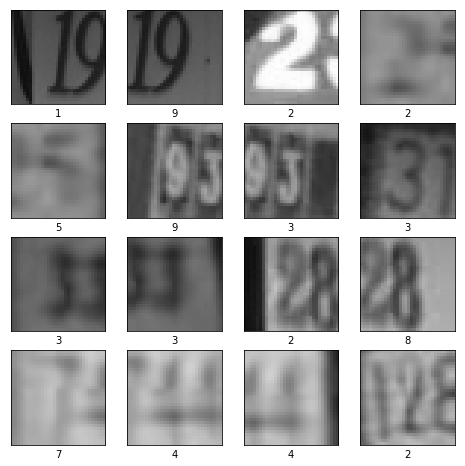

In [8]:
plot_img_grayscale(train_img, train_lbs)

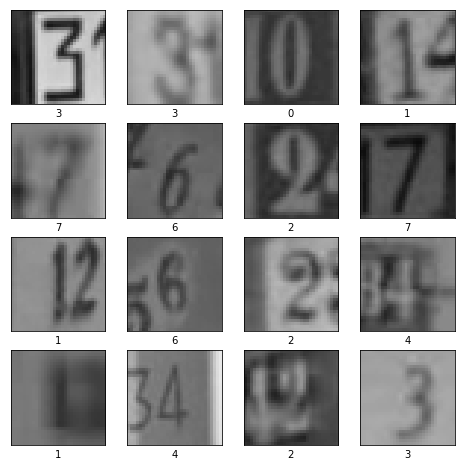

In [9]:
#Check if the validation set is divided correctely and print the data
plot_img_grayscale(validation_img, validation_lbs)

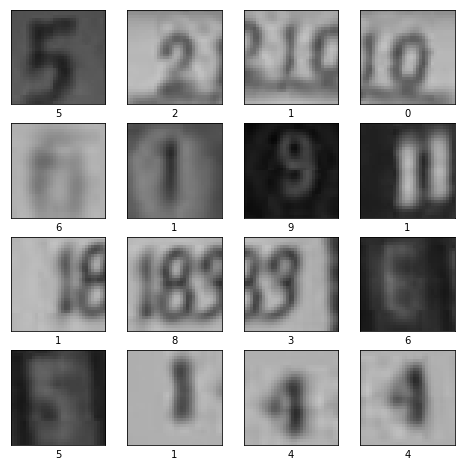

In [10]:
plot_img_grayscale(test_img, test_lbs)

## Data preprocessing

Two techniques are used in this order on the training set:

- **zero centering**: this is achieved by subctracting the mean of each colour channel across said colour channel.
- **normalization**: divide each colour channel by its standard deviation (calculated after zero centering).

The same techniques are applied also on the validation set and test set but using the same parameters (mean and standard deviation) obtained from the training set.

In [11]:
train_mean = np.mean(train_img)
train_img = train_img - train_mean
train_std = np.std(train_img)
train_img = train_img / train_std

#do the same for validation and test set
validation_img = validation_img - train_mean
validation_img = validation_img / train_std
test_img = test_img - train_mean
test_img = test_img / train_std

## Hyper-parameters Optimization

In [12]:
##hyper parameters network structure, batch size, learning rate, drop-out

#do the train
#see what hyperparameters do better on val set
#redo the trainign with the best parameters on val set + train set
#evaluate on training set

#adapt network architecture:
#try max pool instead of stride or vice versa
#try global avarage pooling vs fully connected

In [13]:
#train on 6 epochs
epoch_num = 6

#default batch size
batch = 64

#allows to save the weights for a model in a directory called dir_name
def checkpoint(dir_name):
    return tf.keras.callbacks.ModelCheckpoint(filepath=dir_name+'/cp-{epoch:02d}.hd5', verbose=0, period=3)

#learning rate decay call back    
learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [14]:
#define function to plot accuracy or loss
def plot_validation(history, loss=False):
    number_of_models = len(history)
    if loss:
        name, key, loc, f = 'Loss', 'loss', 'lower left', min
    else:
        name, key, loc, f = 'Accuracy', 'acc', 'upper left', max
    plt.figure(figsize=(8,3))
    for i in range(number_of_models):
        plt.plot(history[i].history['val_'+key], label='val_'+key+str(i))
        print('CNN {0}: Epochs={1:d}, Train {2}={3:.5f}, Validation {2}={4:.5f}'.format(
            i,epoch_num,name,f(history[i].history[key]),f(history[i].history['val_'+key])))
    plt.title('Validation '+ name)
    plt.xlabel('Epochs')
    plt.ylabel(name)
    plt.legend(loc='upper left')
    plt.show()

In [1]:
#funciton to get the index of the model with the best accuracy or loss
def get_best_model(history, loss=False):
    number_of_models = len(history)
    if loss:
        key = 'val_acc'
    else:
        key = 'val_loss'
    max_values = []
    for i in range(number_of_models):
        best_value = max([x for x in history[i].history[key]])
        max_values.append(best_value)
    return max_values.index(max(max_values))

In [15]:
def save_history(hist_list, path):
    for i in range(len(hist_list)):
        json.dump(str(hist_list[i].history), open(path+str(i)+"/hist"+str(i)+".json", 'w'))
    
def load_history(path):
    return json.load(open(path, 'r'))

### Explain the basic structure on their hyper parameters
we are now going ot start hyperparameter evaluation

the basic network structure will be  
(conv2dLayer\* **N** (filterSize\* **L**) -> (maxPool or Stride))\***M** -> (FCnonlinear\***K** -> FCsoftmax) or (Global avarage pooling)

There are two typical architecture: conv layer followed by a max pooling or smaller conv layer followed by a conv layer with stride=2. Here the two are confronted giving each one roughly the same number of convolutional neurons.

In [16]:
val_models = []

models_number = 2
for i in range(models_number):
    model = models.Sequential()
    if i > 0:
        model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
        model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
        model.add(layers.Conv2D(16, (3,3), strides=2, activation='relu'))
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
        model.add(layers.Conv2D(32, (3,3), strides=2, activation='relu'))
    else:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/structure/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=batch, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))


Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 21s 322us/sample - loss: 0.7491 - acc: 0.7750 - val_loss: 0.4797 - val_acc: 0.8663
Epoch 2/6
65932/65932 [==============================] - 21s 318us/sample - loss: 0.4218 - acc: 0.8801 - val_loss: 0.4001 - val_acc: 0.8835
Epoch 3/6
65932/65932 [==============================] - 21s 320us/sample - loss: 0.3404 - acc: 0.9007 - val_loss: 0.3650 - val_acc: 0.8961
Epoch 4/6
65932/65932 [==============================] - 21s 318us/sample - loss: 0.2820 - acc: 0.9180 - val_loss: 0.3571 - val_acc: 0.8972
Epoch 5/6
65932/65932 [==============================] - 21s 319us/sample - loss: 0.2379 - acc: 0.9309 - val_loss: 0.3513 - val_acc: 0.8980
Epoch 6/6
65932/65932 [==============================] - 21s 318us/sample - loss: 0.1987 - acc: 0.9417 - val_loss: 0.3555 - val_acc: 0.9012
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 33s 4

CNN 0: Epochs=6, Train Accuracy=0.94171, Validation Accuracy=0.90116
CNN 1: Epochs=6, Train Accuracy=0.95374, Validation Accuracy=0.91317


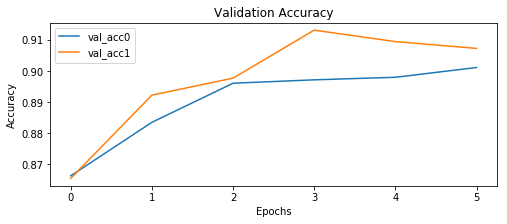

CNN 0: Epochs=6, Train Loss=0.19865, Validation Loss=0.35126
CNN 1: Epochs=6, Train Loss=0.15703, Validation Loss=0.29438


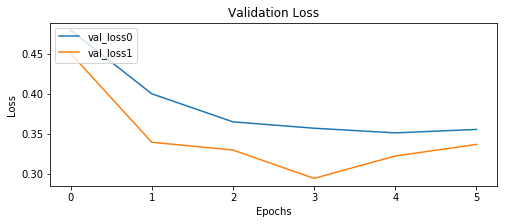

In [18]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [ ]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))

### Validate the number of covolutional layers

In [19]:
val_models = []

models_number = 7
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    if i > 0:
        model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    if i > 3:
        model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(16, (3,3), strides=2, activation='relu'))

    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i > 0:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i > 3:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3,3), strides=2, activation='relu'))
    
    if i == 2 or i == 5:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i == 3 or i == 6:
        model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [20]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/layers/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=batch, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 14s 208us/sample - loss: 0.7849 - acc: 0.7512 - val_loss: 0.4494 - val_acc: 0.8669
Epoch 2/6
65932/65932 [==============================] - 13s 204us/sample - loss: 0.3869 - acc: 0.8849 - val_loss: 0.3672 - val_acc: 0.8891
Epoch 3/6
65932/65932 [==============================] - 14s 209us/sample - loss: 0.3031 - acc: 0.9112 - val_loss: 0.3550 - val_acc: 0.8953
Epoch 4/6
65932/65932 [==============================] - 13s 204us/sample - loss: 0.2444 - acc: 0.9281 - val_loss: 0.3451 - val_acc: 0.8999
Epoch 5/6
65932/65932 [==============================] - 13s 204us/sample - loss: 0.1990 - acc: 0.9413 - val_loss: 0.3422 - val_acc: 0.9062
Epoch 6/6
65932/65932 [==============================] - 13s 204us/sample - loss: 0.1585 - acc: 0.9535 - val_loss: 0.3673 - val_acc: 0.9051
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 33s 5

CNN 0: Epochs=6, Train Accuracy=0.95350, Validation Accuracy=0.90621
CNN 1: Epochs=6, Train Accuracy=0.95351, Validation Accuracy=0.91031
CNN 2: Epochs=6, Train Accuracy=0.95335, Validation Accuracy=0.92027
CNN 3: Epochs=6, Train Accuracy=0.95743, Validation Accuracy=0.92068
CNN 4: Epochs=6, Train Accuracy=0.95325, Validation Accuracy=0.91618
CNN 5: Epochs=6, Train Accuracy=0.95215, Validation Accuracy=0.91085
CNN 6: Epochs=6, Train Accuracy=0.95771, Validation Accuracy=0.91918


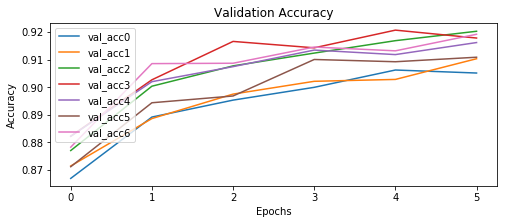

CNN 0: Epochs=6, Train Loss=0.15848, Validation Loss=0.34218
CNN 1: Epochs=6, Train Loss=0.15768, Validation Loss=0.32895
CNN 2: Epochs=6, Train Loss=0.16251, Validation Loss=0.27838
CNN 3: Epochs=6, Train Loss=0.14328, Validation Loss=0.28252
CNN 4: Epochs=6, Train Loss=0.15603, Validation Loss=0.28963
CNN 5: Epochs=6, Train Loss=0.16502, Validation Loss=0.29081
CNN 6: Epochs=6, Train Loss=0.14217, Validation Loss=0.29286


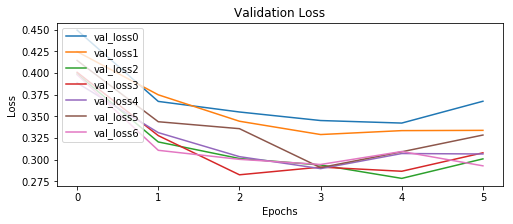

In [21]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [ ]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))

### Validate the number of filters per layer

In [22]:
val_models = []

models_number = 6
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(8+8*i, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(8+8*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(8+8*i, (3,3), strides=2, activation='relu'))

    model.add(layers.Conv2D(16+16*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(16+16*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(16+16*i, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(16+16*i, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [23]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/filters/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=batch, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 18s 271us/sample - loss: 0.7927 - acc: 0.7461 - val_loss: 0.4695 - val_acc: 0.8567
Epoch 2/6
65932/65932 [==============================] - 17s 265us/sample - loss: 0.4087 - acc: 0.8765 - val_loss: 0.3895 - val_acc: 0.8797
Epoch 3/6
65932/65932 [==============================] - 19s 287us/sample - loss: 0.3341 - acc: 0.9003 - val_loss: 0.3531 - val_acc: 0.8939
Epoch 4/6
65932/65932 [==============================] - 17s 264us/sample - loss: 0.2858 - acc: 0.9146 - val_loss: 0.3368 - val_acc: 0.9012
Epoch 5/6
65932/65932 [==============================] - 18s 266us/sample - loss: 0.2502 - acc: 0.9265 - val_loss: 0.3313 - val_acc: 0.9018
Epoch 6/6
65932/65932 [==============================] - 17s 265us/sample - loss: 0.2198 - acc: 0.9345 - val_loss: 0.3510 - val_acc: 0.8997
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 35s 5

CNN 0: Epochs=6, Train Accuracy=0.93454, Validation Accuracy=0.90184
CNN 1: Epochs=6, Train Accuracy=0.96239, Validation Accuracy=0.91195
CNN 2: Epochs=6, Train Accuracy=0.96217, Validation Accuracy=0.92246
CNN 3: Epochs=6, Train Accuracy=0.96381, Validation Accuracy=0.92437
CNN 4: Epochs=6, Train Accuracy=0.96689, Validation Accuracy=0.91863
CNN 5: Epochs=6, Train Accuracy=0.96883, Validation Accuracy=0.92423


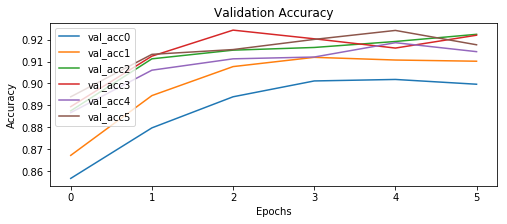

CNN 0: Epochs=6, Train Loss=0.21977, Validation Loss=0.33125
CNN 1: Epochs=6, Train Loss=0.13038, Validation Loss=0.29107
CNN 2: Epochs=6, Train Loss=0.13378, Validation Loss=0.28305
CNN 3: Epochs=6, Train Loss=0.12145, Validation Loss=0.25697
CNN 4: Epochs=6, Train Loss=0.11215, Validation Loss=0.29533
CNN 5: Epochs=6, Train Loss=0.10260, Validation Loss=0.28435


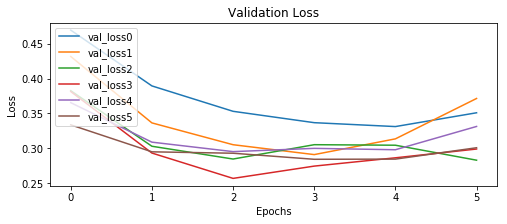

In [24]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [ ]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

In [1]:
#first layer weights
flw = 8+8*best
#second layer weights
slw = 16+16*best

NameError: name 'best' is not defined

### Validate the number neurons in the fully connected layer

In [ ]:
val_models = []

models_number = 5
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(flw, (3,3), strides=2, activation='relu'))

    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(64+64*i, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [ ]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/FC/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=batch, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 140s 2ms/sample - loss: 0.7872 - acc: 0.7438 - val_loss: 0.3513 - val_acc: 0.8941
Epoch 2/6
65932/65932 [==============================] - 140s 2ms/sample - loss: 0.3005 - acc: 0.9121 - val_loss: 0.3410 - val_acc: 0.9027
Epoch 3/6
65932/65932 [==============================] - 142s 2ms/sample - loss: 0.2317 - acc: 0.9326 - val_loss: 0.2821 - val_acc: 0.9147
Epoch 4/6
65932/65932 [==============================] - 140s 2ms/sample - loss: 0.1876 - acc: 0.9459 - val_loss: 0.2748 - val_acc: 0.9223
Epoch 5/6
65932/65932 [==============================] - 140s 2ms/sample - loss: 0.1465 - acc: 0.9581 - val_loss: 0.3000 - val_acc: 0.9225
Epoch 6/6
65932/65932 [==============================] - 141s 2ms/sample - loss: 0.1124 - acc: 0.9677 - val_loss: 0.3037 - val_acc: 0.9207
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 142s 2ms/sa

CNN 0: Epochs=6, Train Accuracy=0.96771, Validation Accuracy=0.92246
CNN 1: Epochs=6, Train Accuracy=0.97077, Validation Accuracy=0.92205
CNN 2: Epochs=6, Train Accuracy=0.97494, Validation Accuracy=0.92382
CNN 3: Epochs=6, Train Accuracy=0.97306, Validation Accuracy=0.92519
CNN 4: Epochs=6, Train Accuracy=0.97367, Validation Accuracy=0.92355


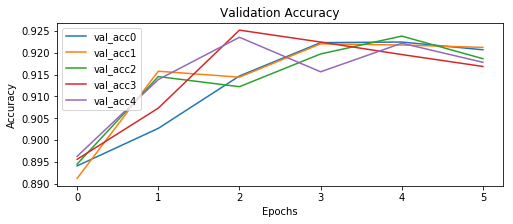

CNN 0: Epochs=6, Train Loss=0.11243, Validation Loss=0.27478
CNN 1: Epochs=6, Train Loss=0.09726, Validation Loss=0.27921
CNN 2: Epochs=6, Train Loss=0.08412, Validation Loss=0.27308
CNN 3: Epochs=6, Train Loss=0.08918, Validation Loss=0.25909
CNN 4: Epochs=6, Train Loss=0.08626, Validation Loss=0.26721


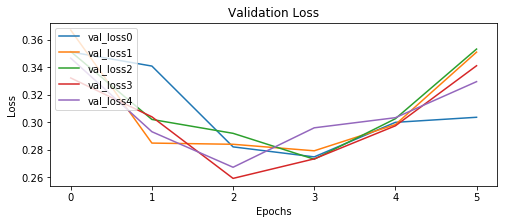

In [ ]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [ ]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

In [ ]:
#fully connected layer weights
fcw = 64+best*64

### Validate droput

In [ ]:
val_models = []

droput = [0.1,0.2,0.3,0.4,0.5,0.6]

models_number = 6
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(flw, (3,3), strides=2, activation='relu'))

    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(fcw, activation='relu'))
    model.add(layers.Dropout(droput[i]))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/dropout/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=batch, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 145s 2ms/sample - loss: 0.7592 - acc: 0.7530 - val_loss: 0.3736 - val_acc: 0.8912
Epoch 2/6
65932/65932 [==============================] - 146s 2ms/sample - loss: 0.3157 - acc: 0.9066 - val_loss: 0.3002 - val_acc: 0.9121
Epoch 3/6
65932/65932 [==============================] - 158s 2ms/sample - loss: 0.2438 - acc: 0.9287 - val_loss: 0.2772 - val_acc: 0.9195
Epoch 4/6
65932/65932 [==============================] - 146s 2ms/sample - loss: 0.1971 - acc: 0.9430 - val_loss: 0.2767 - val_acc: 0.9241
Epoch 5/6
65932/65932 [==============================] - 146s 2ms/sample - loss: 0.1599 - acc: 0.9529 - val_loss: 0.2662 - val_acc: 0.9238
Epoch 6/6
65932/65932 [==============================] - 145s 2ms/sample - loss: 0.1245 - acc: 0.9634 - val_loss: 0.3261 - val_acc: 0.9244
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 147s 2ms/sa

CNN 0: Epochs=6, Train Accuracy=0.96336, Validation Accuracy=0.92437
CNN 1: Epochs=6, Train Accuracy=0.96096, Validation Accuracy=0.92860
CNN 2: Epochs=6, Train Accuracy=0.95341, Validation Accuracy=0.92628
CNN 3: Epochs=6, Train Accuracy=0.95256, Validation Accuracy=0.92819
CNN 4: Epochs=6, Train Accuracy=0.94409, Validation Accuracy=0.92587
CNN 5: Epochs=6, Train Accuracy=0.93766, Validation Accuracy=0.92601


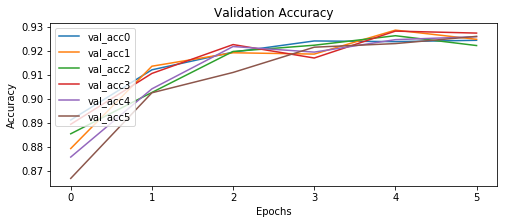

CNN 0: Epochs=6, Train Loss=0.12455, Validation Loss=0.26615
CNN 1: Epochs=6, Train Loss=0.13473, Validation Loss=0.26308
CNN 2: Epochs=6, Train Loss=0.16100, Validation Loss=0.26075
CNN 3: Epochs=6, Train Loss=0.16770, Validation Loss=0.26967
CNN 4: Epochs=6, Train Loss=0.20029, Validation Loss=0.27017
CNN 5: Epochs=6, Train Loss=0.22468, Validation Loss=0.26416


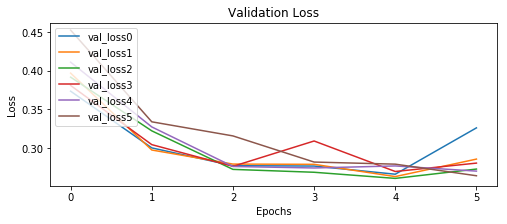

In [ ]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [ ]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

In [ ]:
best_dropout = dropout[best]

### Validate the batch size

In [ ]:
val_models = []

models_number = 6
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(flw, (3,3), strides=2, activation='relu'))

    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(fcw, activation='relu'))
    model.add(layers.Dropout(best_dropout))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [ ]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/batch/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=24+i*24, epochs=epoch_num+3,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/9
65932/65932 [==============================] - 168s 3ms/sample - loss: 2.2426 - acc: 0.1878 - val_loss: 2.2363 - val_acc: 0.1902
Epoch 2/9
65932/65932 [==============================] - 163s 2ms/sample - loss: 2.2378 - acc: 0.1891 - val_loss: 2.2365 - val_acc: 0.1902
Epoch 3/9
65932/65932 [==============================] - 166s 3ms/sample - loss: 2.2372 - acc: 0.1891 - val_loss: 2.2364 - val_acc: 0.1902
Epoch 4/9
65932/65932 [==============================] - 165s 3ms/sample - loss: 2.2370 - acc: 0.1891 - val_loss: 2.2362 - val_acc: 0.1902
Epoch 5/9
65932/65932 [==============================] - 167s 3ms/sample - loss: 2.2368 - acc: 0.1891 - val_loss: 2.2363 - val_acc: 0.1902
Epoch 6/9
65932/65932 [==============================] - 166s 3ms/sample - loss: 2.2367 - acc: 0.1891 - val_loss: 2.2359 - val_acc: 0.1902
Epoch 7/9
65932/65932 [==============================] - 166s 3ms/sample - loss: 2.2366 - acc: 0.1891 - val_loss: 2.2

In [ ]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [ ]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

In [ ]:
best_batch_size = 24+best*24

### Validate Learning rate

In [ ]:
val_models = []

models_number = 5
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(flw, (3,3), strides=2, activation='relu'))

    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(fcw, activation='relu'))
    model.add(layers.Dropout(best_dropout))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [ ]:
#create multiple learning rates
def lrd(i):
    return tf.keras.callbacks.LearningRateScheduler(lambda x: 10**-3 * (0.65 - (0.025*i )) ** x, verbose=0)

In [ ]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/learning_rate/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=best_batch_size, epochs=epoch_num+2+i,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  lrd(i)]))

In [ ]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [ ]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

In [ ]:
best_lr = lrd(best)

### Train the model on the whole training set (train + validation renormalized)

In [ ]:
#reload the datasets and renormalize them, without splitting the validation set.
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')
train_img, train_lbs = train['X'], train['y']
test_img, test_lbs = test['X'], test['y']

train_img = np.transpose(train_img,[3,0,1,2])
test_img = np.transpose(test_img,[3,0,1,2])

train_lbs = np.where(train_lbs!=10, train_lbs, 0)
test_lbs = np.where(test_lbs!= 10, test_lbs, 0)

In [ ]:
def rgb_to_gray(rgb):
    r,g,b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989*r+0.5870*g+0.1140*b
    return gray.reshape(rgb.shape[0], rgb.shape[1], rgb.shape[2], 1)

train_img = rgb_to_gray(train_img)
test_img = rgb_to_gray(test_img)

In [ ]:
train_mean = np.mean(train_img)
train_img = train_img - train_mean
train_std = np.std(train_img)
train_img = train_img / train_std

#do the same for the test set
test_img = test_img - train_mean
test_img = test_img / train_std

In [ ]:
#create the final model
model = models.Sequential()
    
model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(flw, (3,3), strides=2, activation='relu'))

model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(slw, (3,3), strides=2, activation='relu'))
    
model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
        
model.add(layers.Flatten())
model.add(layers.Dense(fcw, activation='relu'))
model.add(layers.Dropout(best_dropout))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/training/model'
os.makedirs(base_name, exist_ok=True)

#train it
history = model.fit(train_img, train_lbs, batch_size=best_batch_size, epochs=10, validation_data=(test_img, test_lbs),
                    verbose = 1, callbacks=[checkpoint(base_name), best_lr])

In [ ]:
save_history([history], base_name)

plot_validation([history])

plot_validation( [history], loss=True)

In [ ]:
model.evaluate(test_img, test_lbs)